# Sentiment analysis using word2vec and LSTM 

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook

from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords


In [2]:
# turn a doc into clean tokens
def clean_doc(doc):
    doc = doc.strip()
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens
    

In [3]:
reviews = pd.read_excel('../data/Bag_Reviews.xlsx')
reviews = reviews[['rating','comments']]
reviews = reviews.drop_duplicates()
# reviews['sentiment'] = 'neutral'
# reviews.loc[(reviews['rating']==1) | (reviews['rating']==2),'sentiment'] = 'negative'
# reviews.loc[(reviews['rating']==4) | (reviews['rating']==5),'sentiment'] = 'positive'
reviews['sentiment'] = -1
reviews.loc[(reviews['rating']==1) | (reviews['rating']==2),'sentiment'] = 0
reviews.loc[(reviews['rating']==4) | (reviews['rating']==5),'sentiment'] = 1
reviews = reviews[reviews.sentiment!=-1]
reviews.head()

,rating,comments,sentiment
0,4,Give 4 stars because order at the price 37 but...,1
1,5,Ordered at a discount of 10 baht per piece. It...,1
2,5,"Small, cute, compact, good But the sash looks ...",1
3,1,The size is not as large as it is down. The st...,0
4,1,The product is compared to the price. Okay. Se...,0


In [4]:
reviews.shape

(2437, 3)

In [5]:
# load doc and add to vocab
def add_doc_to_vocab(doc, vocab):
    
    # clean doc
    tokens = clean_doc(doc)
    # update counts
    vocab.update(tokens)

# load all docs in a directory
def process_docs(directory, vocab, is_trian):
    
    for i in range(len(reviews)):
        doc = reviews.comments.iloc[i]
        add_doc_to_vocab(doc, vocab)

In [6]:
# define vocab
vocab = Counter()
# add all docs to vocab
process_docs('./../data/for_w2v', vocab, True)
# print the size of the vocab
print(len(vocab))
# print the top words in the vocab
print(vocab.most_common(50))

# keep tokens with a min occurrence
min_occurane = 2
tokens = [k for k,c in vocab.items() if c >= min_occurane]
print(len(tokens))


# save list to file
def save_list(lines, filename):
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w')
    # write text
    file.write(data)
    # close file
    file.close()

# save tokens to a vocabulary file'./../data/for_w2v/vocab1.txt'
save_list(tokens, './../data/for_w2v/vocab1.txt')

2423
[('good', 3372), ('product', 1621), ('The', 1265), ('price', 1231), ('Very', 1144), ('quality', 1074), ('delivery', 1032), ('Good', 951), ('value', 878), ('fast', 629), ('beautiful', 476), ('service', 459), ('products', 427), ('shop', 353), ('bag', 348), ('like', 315), ('cheap', 313), ('color', 289), ('But', 276), ('Reed', 261), ('baht', 246), ('worth', 229), ('money', 218), ('cute', 217), ('Beautiful', 208), ('ordered', 202), ('lot', 194), ('Fast', 189), ('small', 168), ('order', 166), ('Received', 165), ('ok', 153), ('shipping', 152), ('suitable', 152), ('according', 146), ('little', 139), ('much', 131), ('well', 131), ('transportation', 129), ('reed', 125), ('Product', 122), ('Order', 121), ('goods', 120), ('sensitive', 119), ('mm', 117), ('speed', 115), ('company', 108), ('time', 105), ('get', 101), ('Not', 101)]
1318


# Modeling

In [7]:
from string import punctuation
from os import listdir
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

Using TensorFlow backend.


In [8]:
# load all docs in a directory
def process_docs0( vocab, is_trian):
    
    text_list = list()
    for i in range(len(reviews)):
        text1 = reviews.comments.iloc[i]
        text3 = clean_doc(text1)
        text_list.append(text3)
        
    return text_list

# load all docs in a directory
def process_docs0_pred( text1):
    
    text_list = list()
    text3 = clean_doc(text1)
    text_list.append(text3)
        
    return text_list

# load all output -ve / +ve
def process_docs1():
    
    outs =list()
    for i in range(len(reviews)):
        text1 = reviews.sentiment.iloc[i]
        text1 = text1.strip()
        outs.append(text1)
    return outs

# load all output -ve / +ve
def process_docs1():
    
    outs =list()
    for i in range(len(reviews)):
        text1 = reviews.sentiment.iloc[i]
        outs.append(text1)
    return outs

In [9]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load embedding as a dict
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename,'r',encoding="utf8")
    lines = file.readlines()
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = asarray(parts[1:], dtype='float32')
    return embedding

# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
            weight_matrix[i] = vector
    return weight_matrix


In [10]:

# load the vocabulary
vocab_filename = './../data/for_w2v/vocab1.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

# load all training reviews
all_docs = process_docs0( vocab, True)
#negative_docs = process_docs('E:/Studies/python/sentimental/review_polarity/txt_sentoken/neg', vocab, True)
train_docs = all_docs[0:2100]
outputs = process_docs1()

# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_docs)

# sequence encode
encoded_docs = tokenizer.texts_to_sequences(train_docs)
# pad sequences
max_length = max([len(s) for s in train_docs])
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# define training labels
ytrain = array(outputs[0:2100])
# load all test reviews

test_docs = all_docs[2101:]
# sequence encode
encoded_docs = tokenizer.texts_to_sequences(test_docs)
# pad sequences
Xtest = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# define test labels
ytest = array(outputs[2101:])

# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1

In [11]:

# load embedding from file
raw_embedding = load_embedding('./../data/for_w2v/glove.6B.100d.txt')
# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
# create the embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_vectors], input_length=max_length, trainable=False)


In [12]:

# define model
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(Xtrain, ytrain, epochs=50, verbose=2)
# evaluate
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 176, 100)          189000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 172, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 86, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11008)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11009     
Total params: 264,137
Trainable params: 75,137
Non-trainable params: 189,000
_________________________________________________________________
None

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
 - 1s - loss: 0

In [13]:
model.predict(Xtest),ytest

(array([[9.9999309e-01],
        [9.9999154e-01],
        [1.0000000e+00],
        [9.9379241e-01],
        [1.0000000e+00],
        [6.9242406e-01],
        [9.9989557e-01],
        [8.2721192e-01],
        [1.0000000e+00],
        [9.9871981e-01],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [9.9972689e-01],
        [9.3413448e-01],
        [9.9999964e-01],
        [1.0000000e+00],
        [5.5621046e-01],
        [1.0000000e+00],
        [1.0000000e+00],
        [9.9999994e-01],
        [5.2913696e-01],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [9.9942130e-01],
        [5.7800376e-01],
        [1.0000000e+00],
        [3.2994556e-01],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [9.8299617e-01],
        [1.0000000e+00],
        [1.0000000e+00],


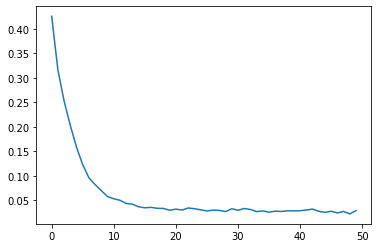

In [15]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'])

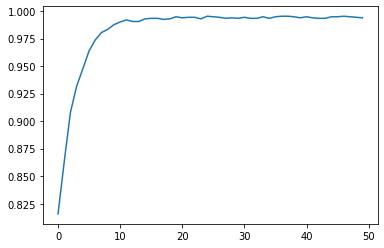

In [17]:
plt.plot(model.history.history['acc'])

In [18]:
def process_text_for_pred(text):
    text = process_docs0_pred(text)
    # sequence encode
    encoded_docs = tokenizer.texts_to_sequences(text)
    # pad sequences
    Xtest1 = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    
    return Xtest1

In [28]:
text = 'size of this item is too small than i excpected,i dont want this '
#text = reviews.comments.iloc[len(reviews)-10]
text = process_text_for_pred(text)

model.predict(text)

array([[0.5828323]], dtype=float32)

In [20]:
reviews.comments.iloc[len(reviews)-10]

'Send good price for 10 baht. This price does not have to think much. Buy mobile phone, pay for the market. It is considered worth it.'

## Plots

In [6]:
from bokeh.io import output_notebook,show, push_notebook
from bokeh.layouts import widgetbox,column,row
from bokeh.models.widgets import Dropdown,PreText, Select

from bokeh.models import HoverTool
from bokeh.plotting import curdoc,figure
from ipywidgets import interact

from bokeh.models import ColumnDataSource

output_notebook()

Loading BokehJS ...

In [9]:

menu = ['negative','positive']
menu = menu

def update(category):
    if category == 'negative':
        reviews_ms1 = reviews[reviews.sentiment==0].iloc[0:10]
    else:
        reviews_ms1 = reviews[reviews.sentiment==1].iloc[0:10]

    push_notebook()
    
    plot_all(reviews_ms1)

    
def plot_all(reviews_ms1):
    print('--------------------------------------------------------------------------------')
    print('------------------------------ reviews -----------------------------------------')
    print('--------------------------------------------------------------------------------')
    for i in range(len(reviews_ms1)):
        print(reviews_ms1.comments.iloc[i])
        
        print('--------------------------------------------------------------------------------')

In [10]:
interact(update,category = menu)

interactive(children=(Dropdown(description='category', options=('negative', 'positive'), value='negative'), Ou…

<function __main__.update(category)>